In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [173]:
df = pd.read_csv("processed_data.csv")

embedding_caption = np.load("embedding_caption_mean.npy")
embedding_script = np.load("embedding_script_mean.npy")

In [174]:
features_num = df[["is_ad", "is_sponsored", "author_fans"]].values
X_text = np.hstack([embedding_caption, embedding_script])

y = df["manual_score_log_class_qcut"]
le = LabelEncoder()
y_enc = le.fit_transform(y)

In [175]:
X_text_train, X_text_test, features_num_train, features_num_test, y_train, y_test = train_test_split(
    X_text, features_num, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

scaler = StandardScaler()
features_num_train_scaled = scaler.fit_transform(features_num_train)
features_num_test_scaled = scaler.transform(features_num_test)

X_train = np.hstack([X_text_train, features_num_train_scaled])
X_test = np.hstack([X_text_test, features_num_test_scaled])

In [176]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [177]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)


input_size = X_train.shape[1]
num_classes = len(np.unique(y_enc))
model = MLPClassifier(input_size, num_classes)

In [178]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
epochs = 100

loss_history = []
acc_history = []

best_loss = float('inf')
patience = 3
counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total

    loss_history.append(avg_loss)
    acc_history.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Acc: {accuracy:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
    else:
        counter += 1
        print(f"  No improvement. Patience: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered!")
            break

Epoch 1/100 - Loss: 1.1548 - Acc: 0.3597
Epoch 2/100 - Loss: 1.1088 - Acc: 0.4133
Epoch 3/100 - Loss: 1.0759 - Acc: 0.4261
Epoch 4/100 - Loss: 1.0348 - Acc: 0.5011
Epoch 5/100 - Loss: 0.9802 - Acc: 0.5353
Epoch 6/100 - Loss: 0.9280 - Acc: 0.5846
Epoch 7/100 - Loss: 0.9249 - Acc: 0.5696
Epoch 8/100 - Loss: 0.8989 - Acc: 0.6017
Epoch 9/100 - Loss: 0.8588 - Acc: 0.6552
Epoch 10/100 - Loss: 0.8615 - Acc: 0.6745
  No improvement. Patience: 1/3
Epoch 11/100 - Loss: 0.8078 - Acc: 0.7109
Epoch 12/100 - Loss: 0.8049 - Acc: 0.7216
Epoch 13/100 - Loss: 0.7701 - Acc: 0.7216
Epoch 14/100 - Loss: 0.7172 - Acc: 0.7816
Epoch 15/100 - Loss: 0.7295 - Acc: 0.7473
  No improvement. Patience: 1/3
Epoch 16/100 - Loss: 0.7300 - Acc: 0.7730
  No improvement. Patience: 2/3
Epoch 17/100 - Loss: 0.6952 - Acc: 0.7987
Epoch 18/100 - Loss: 0.7166 - Acc: 0.7944
  No improvement. Patience: 1/3
Epoch 19/100 - Loss: 0.6525 - Acc: 0.8351
Epoch 20/100 - Loss: 0.6636 - Acc: 0.8073
  No improvement. Patience: 1/3
Epoch 21/

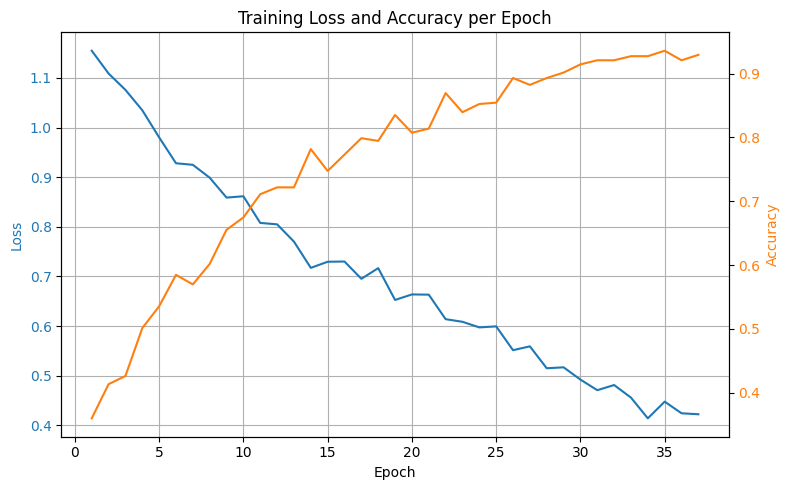

In [179]:
epochs_range = range(1, len(loss_history) + 1)

fig, ax1 = plt.subplots(figsize=(8,5))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs_range, loss_history, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(epochs_range, acc_history, color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Training Loss and Accuracy per Epoch')
fig.tight_layout()
plt.show()

In [180]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=le.classes_))


=== Classification Report ===
              precision    recall  f1-score   support

        high       0.36      0.26      0.30        19
         low       0.49      0.58      0.53        53
      medium       0.40      0.36      0.38        45

    accuracy                           0.44       117
   macro avg       0.42      0.40      0.40       117
weighted avg       0.43      0.44      0.44       117



In [181]:
torch.save(model.state_dict(), 'mlp_classifier_qcut.pth')